# Main cluster's polygons (Brute force)

In this notebook we will show how to remove the polygons of the external layer of the neighborhood of the quasiperiodic lattice created around an arbitrary point.

Also, with that algorithm, we developed a function that iterates that algorithm to eliminate the last N layers of any set of polygons in the quasiperiodic lattice.

Then, we show how to obtain the area of the Voronoi's polygons associated with the polygons in the quasiperiodic lattice that form the principal cluster.

Let's load the files that will be used in this notebook.

In [1]:
include("Operaciones_Basicas.jl")
include("Red_Dual.jl")
include("Separacion_Arreglos_X_Y.jl")
include("Generador_Vecindades_Pto_Arbitrario.jl")
include("voronoi.jl")
include("Algoritmo_Voronoi.jl")
include("Diccionario_Indices_Centroides_Voronoi.jl")
include("Algoritmo_Sir_Davos_Algoritmo_Areas.jl")

arreglo_Areas_Buenos_Poligonos (generic function with 1 method)

We will use the package "Plots" to visualize the polygons of the Neighborhood and the Voronoi's polygons. So, let's load it.

In [2]:
using Plots
gr();

### Information about the Quasiperiodic Lattice

Create the information of the star vectors required by the GDM algorithm, which determine the symmetry of the quasiperiodic lattice. Also, generate the array that contains the alpha constants and the array with the average distance between stripes.

In [3]:
NSides = 5; #Symmetry of the quasiperiodic lattice

Star_Vectors = [[BigFloat(1),0]]; #Array wich will contain the Star Vectors

for i in 1:(NSides-1)
    push!(Star_Vectors, [cos((2*i)*pi/NSides), sin((2*i)*pi/NSides)]); #Complete the Star_Vector Array
end

Alphas_Array = fill(0.2, NSides); #Array of the alphas constant

Average_Distance_Stripes = fill(NSides/2, NSides); #Array with the average distance between stripes

### Neighborhood of the quasiperiodic lattice around an arbitrary point

First, let's get the set of points that will define the polygons in the quasiperiodic lattice around an arbitrary point

In [4]:
N = 1; #Margin of error in the integer numbers generated as the projection of the arbitrary point into the star vectors
SL = 1e7; #Size of a half side of the square in which the algorithm generate a random point inside it

#Let's get the X and Y coordinates of the vertices of the polygons, also get the coordinates of the point around which
#the neighborhood was generated
X, Y, APoint = region_Local_Voronoi(N, SL, Average_Distance_Stripes, Star_Vectors, Alphas_Array);

#Let's get the X and Y coordinates of the centroids of the polygons generated previously, also get the coordinates as
#tuples of the centroids and the dictionary that relates the centroid's coordinates with the polygons vertices' coordi-
#nates of the polygon that generate the centroid.
X_Centroids, Y_Centroids, Centroids, Centroids_Dictionary = centroides(X, Y);

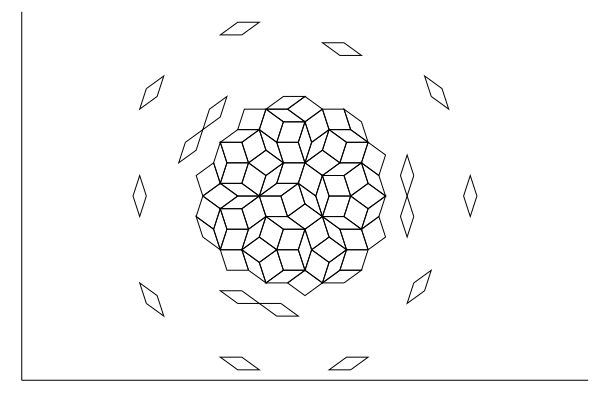

In [5]:
#Let's visualize the set of polygons generated in the previous cell
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black, xaxis = nothing, yaxis = nothing)
end
plot!()

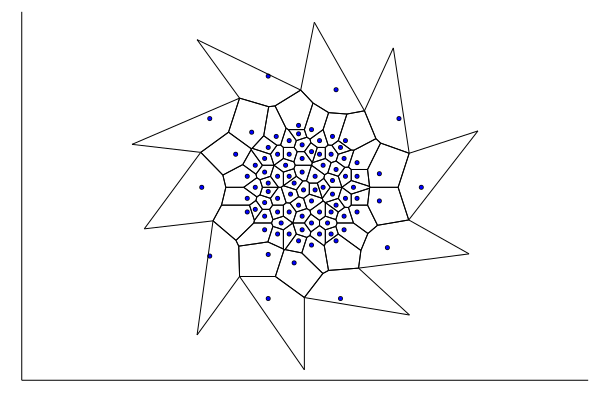

In [6]:
#Let's generate the Voronoi's polygons associated with these polygons in the quasiperiodic lattice
sites = [(Float64(X_Centroids[i]), Float64(Y_Centroids[i])) for i in 1:length(X_Centroids)]

voronoi = getVoronoiDiagram(sites); #Generate all the structure of the Voronoi's algorithm

plot()
for face in voronoi.faces
    scatter!(face.site, color="blue", markersize = 2, xaxis = nothing, yaxis = nothing); #Visualize the centroids that were used to generate the Voronoi's polygons
    
    halfedge = face.outerComponent; #It's associated to one side of the Voronoi's Polygon
    
    while true
        p0 = halfedge.origin.coordinates #The point in which the side of the VP start
        p1 = halfedge.next.origin.coordinates #The point in which this common side of the VP start in the other VP

        plot!([p0, p1], color="black", xaxis = nothing, yaxis = nothing)

        halfedge = halfedge.next; #Pass to the next side of the VP
        if halfedge == face.outerComponent #This condition states that we finish the search of sides
            break
        end
    end
end
plot!(aspect_ratio=:equal, legend=false)

### Eliminating the polygons of the outer layers in the Voronoi's polygons

Now, let's eliminate the polygons in the Voronoi's polygons that corresponds to the external layer. We can identify those because they have infinte area associated with.

So, in this version of the voronoi algorithm, the function "centroides_Sin_Poligono()" give us the centroids whose, in the Voronoi's algorithm, correspond to Voronoi's polygons that are have infinite area.

In [7]:
#Let's get the centroids that correspond to a open Voronoi's polygons
External_Layer_Sites = centroides_Sin_Poligono(voronoi); #Array with the indices of the external polygons

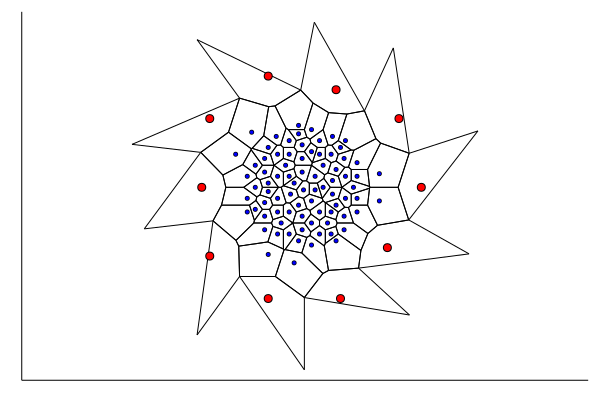

In [8]:
#Let's visualize those centroids as red points
for i in External_Layer_Sites
    scatter!([i[1]], [i[2]], color = "red", xaxis = nothing, yaxis = nothing);
end
plot!()

Now that we know whose centroids corresponds to open Voronoi's polygons, we can erase them of the "Centroids" array and, with the "Centroids_Dictionary" visualize the new neighborhood of the quasiperiodic lattice without those polygons.

In [9]:
#Let's remove the centroids of the "Centroids" array associated with polygons of the external layer
for i in External_Layer_Sites
    deleteat!(Centroids,findfirst(x -> x == i, Centroids))
end

#Redefine the set of X and Y coordinates of the vertices of the neighborhood
X, Y = centroides_A_Vertices(Centroids, Centroids_Dictionary); #Obtain the Coordinates of the polygon's vertices that give rise to a given centroid

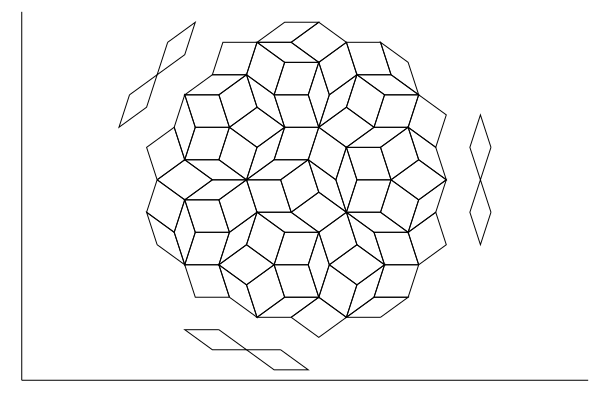

In [10]:
#Let's visualize the new neighborhood of the quasiperiodic lattice
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black, xaxis = nothing, yaxis = nothing)
end
plot!()

Now, we can iterate this algorithm so we will eliminate, in each step, the new external layer of the quasiperiodic lattice

In [11]:
#Recalculate the Voronoi's polygons after removing the external layer
sites = [(Centroids[i][1], Centroids[i][2]) for i in 1:length(Centroids)]
voronoi = getVoronoiDiagram(sites);

In [12]:
#Let's get the centroids that correspond to a open Voronoi's polygons
External_Layer_Sites = centroides_Sin_Poligono(voronoi); #Arreglo con los centroides de los polígonos a quitar

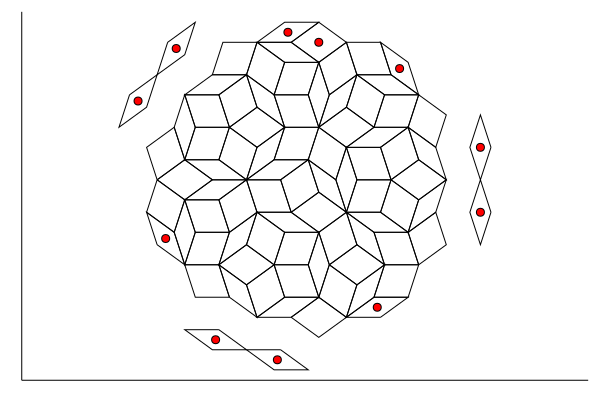

In [13]:
#Let's visualize those centroids as red points
for i in External_Layer_Sites
    scatter!([i[1]], [i[2]], color = "red");
end
plot!()

In [14]:
#Let's remove the centroids of the "Centroids" array associated with polygons of the external layer
for i in External_Layer_Sites
    deleteat!(Centroids,findfirst(x -> x == i, Centroids))
end

#Redefine the set of X and Y coordinates of the vertices of the neighborhood
X, Y = centroides_A_Vertices(Centroids, Centroids_Dictionary); #Obtain the Coordinates of the polygon's vertices that give rise to a given centroid

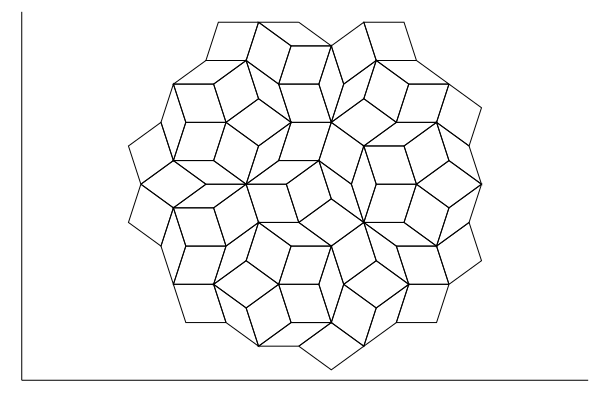

In [15]:
#Let's visualize the new neighborhood of the quasiperiodic lattice
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black,xaxis = nothing, yaxis = nothing)
end
plot!()

And so on ... we can continue removing more layers until we reach the last layer and then, we cannot continue because there will be no more "external layers" to remove.

### Sir Davos Seaworth Algorithm (Or the "Peel the Onion" algorithm)

In general, we would like to iterate the previous steps without copy and pasting them, so the function "algoritmo_Sir_Davos!()" will do that for us.

The algorithm removes, from a given set of centroids, the "N" outermost layers and gives back the new set of centroids without those layers. Note that the function modify the array "Centroids", so be careful about that.

In [16]:
#Let's generate a neighborhood around a new arbitrary point.
N = 5; #Margin of error in the integer numbers generated as the projection of the arbitrary point into the star vectors
SL = 1e7; #Size of a half side of the square in which the algorithm generate a random point inside it

#Let's get the X and Y coordinates of the vertices of the polygons, also get the coordinates of the point around which
#the neighborhood was generated
X, Y, APoint = region_Local_Voronoi(N, SL, Average_Distance_Stripes, Star_Vectors, Alphas_Array);

#Let's get the X and Y coordinates of the centroids of the polygons generated previously, also get the coordinates as
#tuples of the centroids and the dictionary that relates the centroid's coordinates with the polygons vertices' coordi-
#nates of the polygon that generate the centroid.
X_Centroids, Y_Centroids, Centroids, Centroids_Dictionary = centroides(X, Y);

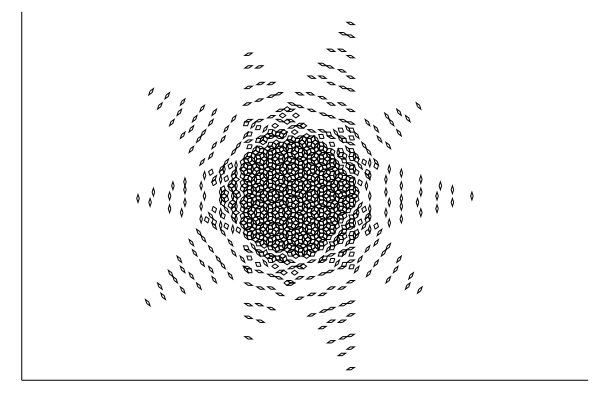

In [17]:
#Let's visualize the set of polygons generated in the previous cell
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black,xaxis = nothing, yaxis = nothing)
end
plot!()

In [18]:
NLayers = 15; #The number of layers to remove

#Let's remove them
algoritmo_Sir_Davos!(Centroids, NLayers);

#Redefine the set of X and Y coordinates of the vertices of the neighborhood
X, Y = centroides_A_Vertices(Centroids, Centroids_Dictionary); #Obtain the Coordinates of the polygon's vertices that give rise to a given centroid

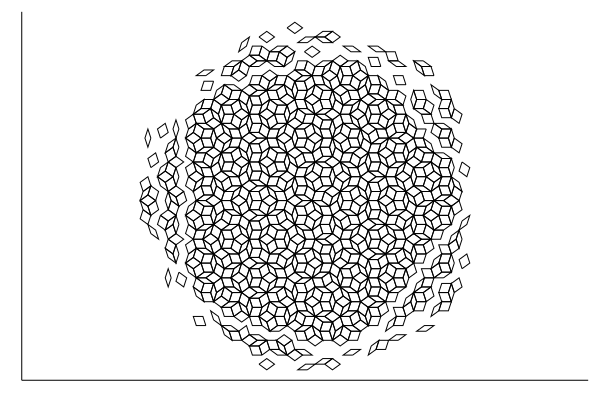

In [19]:
#Let's visualize the new neighborhood of the quasiperiodic lattice
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black, xaxis = nothing, yaxis = nothing)
end
plot!()

### Main cluster areas

With the Sir Davos Seaworth algorithm we can now, for a given set of polygons in the quasiperiodic lattice, obtain the main cluster of them, removing the isolated polygons and minor clusters.

At this moment, I don't know how to calculate the number of outer layers to be removed until reaching the main cluster, so it is necessary to do this to trial and error.

The process to get the Voronoi's polygon's areas of the main cluster it's the next one:

1.- Find the number of layers to be removed that ensures you get the main cluster in each iteration of the neighborhood generation (generally, one or two more layers than the number of layers that removes all the external layers of the main cluster, this because the possible deformations in the outer layers of the main cluster in the Voronoi's lattice)

2.- Calculate the area of the Voronoi's polygons associated with the centroids that live in the main cluster. This area calculations must be done in the original (main cluster and isolated polygons and minor clusters) set of Voronoi's polygons because, removing each layer, modify the Voronoi's polygons, so calculating in the Voronoi's polygons of the main cluster will give bad areas.

In [20]:
NSides = 22; #Symmetry of the quasiperiodic lattice

Star_Vectors = [[BigFloat(1),0]]; #Array wich will contain the Star Vectors

for i in 1:(NSides-1)
    push!(Star_Vectors, [cos((2*i)*pi/NSides), sin((2*i)*pi/NSides)]); #Complete the Star_Vector Array
end

Alphas_Array = fill(0.2, NSides); #Array of the alphas constant

Average_Distance_Stripes = fill(NSides/2, NSides); #Array with the average distance between stripes

In [21]:
#Let's generate a neighborhood around a new arbitrary point.
N = 1; #Margin of error in the integer numbers generated as the projection of the arbitrary point into the star vectors
SL = 1e7; #Size of a half side of the square in which the algorithm generate a random point inside it

#Let's get the X and Y coordinates of the vertices of the polygons, also get the coordinates of the point around which
#the neighborhood was generated
X, Y, APoint = region_Local_Voronoi(N, SL, Average_Distance_Stripes, Star_Vectors, Alphas_Array);

#Let's get the X and Y coordinates of the centroids of the polygons generated previously, also get the coordinates as
#tuples of the centroids and the dictionary that relates the centroid's coordinates with the polygons vertices' coordi-
#nates of the polygon that generate the centroid.
X_Centroids, Y_Centroids, Centroids, Centroids_Dictionary = centroides(X, Y);

In [22]:
#Let's get the initial Voronoi's Lattice
sites = [(Centroids[i][1], Centroids[i][2]) for i in 1:length(Centroids)]
Initial_Voronoi = getVoronoiDiagram(sites);

In [23]:
Copy_Centroids = copy(Centroids); #Let's work with a copy of the original Centroids array

NLayers = 60; #The number of layers to remove

#Let's remove them
algoritmo_Sir_Davos!(Copy_Centroids, NLayers);

#Redefine the set of X and Y coordinates of the vertices of the neighborhood
X, Y = centroides_A_Vertices(Copy_Centroids, Centroids_Dictionary); #Obtain the Coordinates of the polygon's vertices that give rise to a given centroid

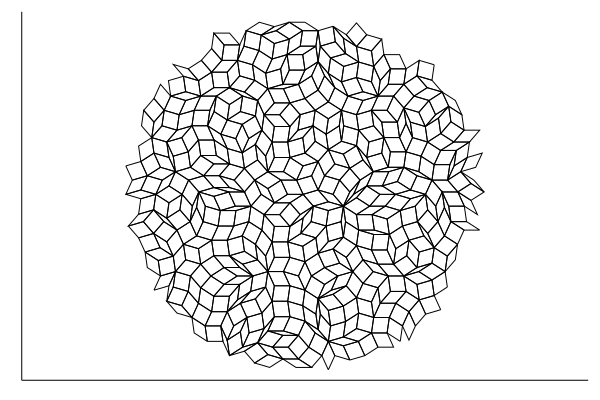

In [24]:
#Let's visualize the new neighborhood of the quasiperiodic lattice
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black, xaxis = nothing, yaxis = nothing)
end
plot!()
#plot!(xlimit = [APoint[1]-13, APoint[1]+13], ylimit = [APoint[2]-13, APoint[2]+13])

In [25]:
#Obtain the dictionary "Centroids -> Voronoi Index" in the Initial Configuration
Centroids_Voronoi_Dictionary = diccionario_Centroides_Indice_Voronoi(sites, Initial_Voronoi);

#Let's calculate the areas of the main cluster's polygons
@time Main_Cluster_Areas = area_Poligonos_Voronoi_Ultima_Capa(Copy_Centroids, Centroids_Voronoi_Dictionary, Initial_Voronoi);

#Minimum and maximum area of the main cluster's polygons
println("The maximum area of the main cluster's polygons is: $(maximum(Main_Cluster_Areas))")
println("The minimum area of the main cluster's polygons is: $(minimum(Main_Cluster_Areas))")

  0.021042 seconds (14.29 k allocations: 655.103 KiB)
The maximum area of the main cluster's polygons is: 1.005859375
The minimum area of the main cluster's polygons is: 0.42578125
